In [1]:
## Environment and packages
using Pkg; Pkg.activate("../../."); 
# Pkg.instantiate()

  Activating environment at `~/Desktop/Jordi/Julia/odinn_toy_model/Project.toml`


In [2]:
using HDF5
using JLD
using LinearAlgebra
using Statistics
using Zygote
using PaddedViews
using Flux
using Flux: @epochs
using Tullio
using Plots; gr()

Plots.GRBackend()

In [3]:
#nx, ny = 100, 100 # Size of the grid This are defined later 

# these in should be 50m, but we are using 1 in MWE_iceflow.jl
Δx, Δy = 50, 50 # meters 
Δt = 1.0/12.0 # timestep in years
t = 0
t₁ = 3

# Numerical method parameters
tolnl = 0.0 # 1e-4  # this ensures that we are going to run always itMax iterations, independenly of the error
itMax = 100
damp = 0.85
dτsc   = 1.0/3.0
ϵ     = 1e-4            # small number
nout = 25                # error check frequency
cfl  = max(Δx^2,Δy^2)/4.1
D_max = 5000000 # maximum value of expected diffusivity

# Glacier parameters 
#A₀ = 1
ρ = 900 # wrong units? Should it be 900 kg/m^3?
g = 9.81
n = 3

3

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/Bolib001/.julia/packages/PlotUtils/ebPq2/src/ticks.jl:295


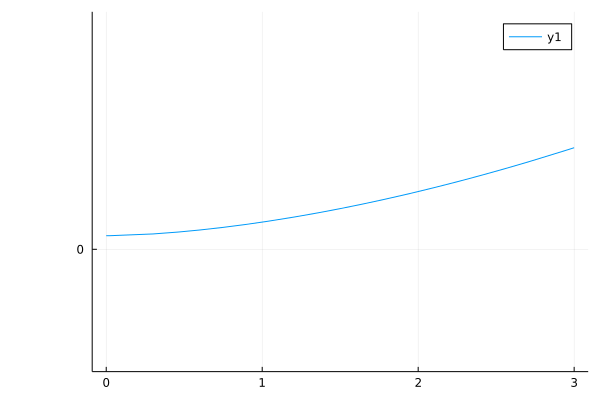

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/Bolib001/.julia/packages/PlotUtils/ebPq2/src/ticks.jl:295


In [4]:
fakeA(t) = (1 + t^1.7)*1e-17
plot(fakeA, 0, t₁)

In [5]:
@views avg(A) = 0.25 * ( A[1:end-1,1:end-1] .+ A[2:end,1:end-1] .+ A[1:end-1,2:end] .+ A[2:end,2:end] )
@views avg_x(A) = 0.5 .* ( A[1:end-1,:] .+ A[2:end,:] )
@views avg_y(A) = 0.5 .* ( A[:,1:end-1] .+ A[:,2:end] )

avg_y (generic function with 1 method)

In [6]:
function iceflow!(H,t,t₁)

    println("Running forward PDE ice flow model...\n")
    # Instantiate variables
    
    let             

    total_iter = 0
    ts_i = 1

    # Manual explicit forward scheme implementation
    while t < t₁
            
        let
        iter = 1
        err = 10e10
        Hold = copy(H) # hold value of H for the other iteration in the implicit method
        dHdt = zeros(nx, ny) # with Tullio

        # Get current year for MB and ELA
        year = floor(Int, t) + 1

        A = fakeA(t)

        while err > tolnl && iter < itMax+1

            Err = copy(H)

            # Compute the Shallow Ice Approximation in a staggered grid
            F, dτ = SIA(H, A)

            # implicit method with Tullio  
            @tullio ResH[i,j] := -(H[i,j] - Hold[i,j])/Δt + F[pad(i-1,1,1),pad(j-1,1,1)]

            dHdt_ = copy(dHdt)
            @tullio dHdt[i,j] := dHdt_[i,j]*damp + ResH[i,j]

            H_ = copy(H)
            @tullio H[i,j] := max(0.0, H_[i,j] + dHdt[i,j]*dτ[pad(i-1,1,1),pad(j-1,1,1)]) 


            if mod(iter, nout) == 0
                # Compute error for implicit method with damping
                Err = Err .- H
                err = maximum(Err)
                println("error at iter ", iter, ": ", err)

                if isnan(err)
                    error("""NaNs encountered.  Try a combination of:
                                decreasing `damp` and/or `dtausc`, more smoothing steps""")
                elseif err>10e8
                    error("""Inestability detected""")
                end
            end

            iter += 1
            total_iter += 1
        end

        t += Δt

        end

    end 

    #println("Total Number of iterartions: ", total_iter)
    end

    println("Saving reference data")
    save(joinpath(root_dir, "data/H_ref.jld"), "H", H)

    return H
end

iceflow! (generic function with 1 method)

In [23]:
function SIA(H, A)

    # Update glacier surface altimetry
    S = B .+ H

    # All grid variables computed in a staggered grid
    # Compute surface gradients on edges
    dSdx  = diff(S, dims=1) / Δx
    dSdy  = diff(S, dims=2) / Δy
    ∇S = sqrt.(avg_y(dSdx).^2 .+ avg_x(dSdy).^2)

    Γ = 2 * A * (ρ * g)^n / (n+2)
    
    D = Γ .* avg(H).^(n + 2) .* ∇S.^(n - 1) 
  
    # Compute flux components
    dSdx_edges = diff(S[:,2:end - 1], dims=1) / Δx
    dSdy_edges = diff(S[2:end - 1,:], dims=2) / Δy
    Fx = .-avg_y(D) .* dSdx_edges
    Fy = .-avg_x(D) .* dSdy_edges    
    #  Flux divergence
    F = .-(diff(Fx, dims=1) / Δx .+ diff(Fy, dims=2) / Δy) # MB to be added here 

    # Compute dτ for the implicit method
    if D_max < maximum(D)
        error("Upper bound of diffusivity reached. Increase the value of D_max to ensure stability. ")
    end
    # dτ = dτsc * min.( 10.0 , 1.0./(1.0/Δt .+ 1.0./(cfl./(ϵ .+ avg(D)))))
    dτ = dτsc * min( 10.0 , 1.0/(1.0/Δt + 1.0/(cfl/(ϵ + D_max))))


    return F, dτ

end

SIA (generic function with 1 method)

### Generate reference dataset

In [8]:
#dataset = 'fake'
dataset = "Argentiere"

if dataset == "fake"

    H₀ = [ 250 * exp( - ( (i - nx/2)^2 + (j - ny/2)^2 ) / 300 ) for i in 1:nx, j in 1:ny ]
    
elseif dataset == "Argentiere"
    
    root_dir = cd(pwd, "../../.")
    argentiere_f = h5open(joinpath(root_dir, "data/Argentiere_2003-2100_aflow2e-16_50mres_rcp2.6.h5"), "r")
    # root_dir = "/Users/facundosapienza/Dropbox/Glacier UDE/ODINN_toy" #cd(pwd, ".")
    # argentiere_f = h5open(joinpath(root_dir, "data/Argentiere_2003-2100_aflow2e-16_50mres_rcp2.6.h5"), "r")

    mutable struct Glacier
        bed::Array{Float64}    # bedrock height
        thick::Array{Float64}  # ice thickness
        vel::Array{Float64}    # surface velocities
        MB::Array{Float64}     # surface mass balance
        lat::Float64
        lon::Float64
    end
    
    # Fill the Glacier structure with the retrieved data
    argentiere = Glacier(HDF5.read(argentiere_f["bed"])[begin:end-2,:],
                         HDF5.read(argentiere_f["thick_hist"])[begin:end-2,:,2:end],
                         HDF5.read(argentiere_f["vel_hist"])[begin:end-2,:,2:end],
                         HDF5.read(argentiere_f["s_apply_hist"])[begin:end-2,:,2:end],
                         0, 0);
    
    nx = size(argentiere.bed)[1]
    ny = size(argentiere.bed)[2]
    
    H₀ = argentiere.thick[:,:,1]
    B  = copy(argentiere.bed)
    
end

193×189 Matrix{Float64}:
 1334.0  1324.0  1310.0  1296.0  1285.0  …  2348.0  2338.0  2326.0  2318.0
 1347.0  1337.0  1320.0  1303.0  1289.0     2318.0  2306.0  2294.0  2284.0
 1362.0  1351.0  1335.0  1316.0  1299.0     2270.0  2260.0  2244.0  2234.0
 1372.0  1364.0  1349.0  1331.0  1313.0     2210.0  2206.0  2194.0  2188.0
 1380.0  1374.0  1362.0  1349.0  1333.0     2150.0  2154.0  2152.0  2150.0
 1385.0  1381.0  1375.0  1366.0  1354.0  …  2108.0  2118.0  2124.0  2126.0
 1389.0  1388.0  1386.0  1382.0  1375.0     2088.0  2098.0  2106.0  2110.0
 1396.0  1396.0  1397.0  1397.0  1394.0     2078.0  2086.0  2094.0  2100.0
 1408.0  1408.0  1409.0  1410.0  1410.0     2074.0  2080.0  2088.0  2094.0
 1424.0  1424.0  1424.0  1425.0  1426.0     2072.0  2078.0  2086.0  2092.0
 1445.0  1444.0  1442.0  1442.0  1444.0  …  2072.0  2076.0  2084.0  2092.0
 1468.0  1465.0  1462.0  1462.0  1466.0     2070.0  2076.0  2084.0  2090.0
 1492.0  1489.0  1485.0  1485.0  1490.0     2072.0  2078.0  2084.0  2090.0


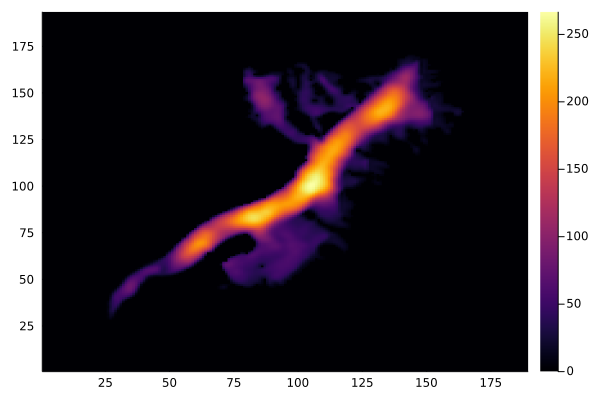

In [9]:
heatmap(H₀, clim=(0, maximum(H₀)))

In [10]:
# Make simulation for reference training matrix and store it
# H_ref = iceflow!(H₀,t,t₁)

Load stored H ref matrix for training

In [11]:
H_ref = load(joinpath(root_dir, "data/H_ref.jld"))["H"]

193×189 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

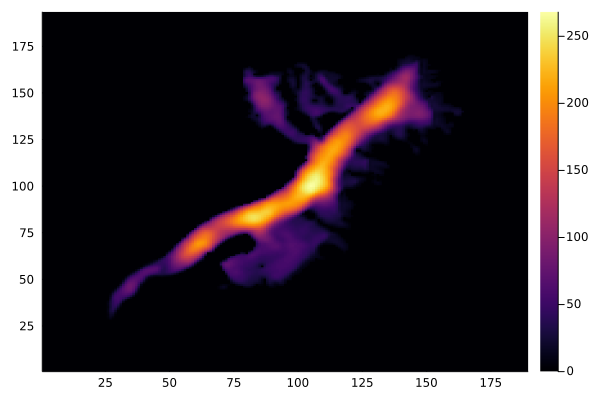

In [12]:
heatmap(H_ref, clim=(0, maximum(H_ref)))

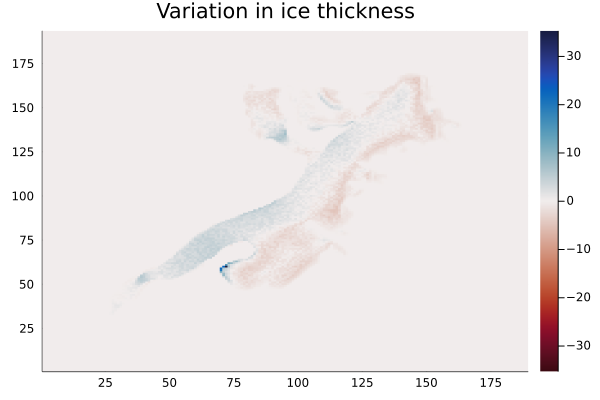

In [13]:
lim = maximum( abs.(H_ref .- H₀) )
heatmap(H_ref .- H₀, c = cgrad(:balance,rev=true),   clim = (-lim, lim), title="Variation in ice thickness")

In [14]:
lim

35.29641139228356

## Learning `A` with an UDE

In [15]:
function iceflow!(H, UA, t, t₁)

    # Retrieve input variables  
    let                  
    current_year = 0
    total_iter = 0
    t = 0

    # Forward scheme implementation
    while t < t₁
        let
        iter = 1
        err = 2 * tolnl
        Hold = copy(H)
        dHdt = zeros(nx, ny)
        err = Inf 

        YA = predict_A(UA, [t])
            
        while err > tolnl && iter < itMax+1

            #println("iter: ", iter)
        
            Err = copy(H)

            # Compute the Shallow Ice Approximation in a staggered grid
            F, dτ = SIA(H, YA)

            # Compute the residual ice thickness for the inertia
            @tullio ResH[i,j] := -(H[i,j] - Hold[i,j])/Δt + F[pad(i-1,1,1),pad(j-1,1,1)]

            dHdt_ = copy(dHdt)
            @tullio dHdt[i,j] := dHdt_[i,j]*damp + ResH[i,j]
                            
            # We keep local copies for tullio
            H_ = copy(H)
            
            # Update the ice thickness
            # @tullio H[i,j] := max(0.0, H_[i,j] + dHdt[i,j]*dτ[pad(i-1,1,1),pad(j-1,1,1)])
            @tullio H[i,j] := max(0.0, H_[i,j] + dHdt[i,j]*dτ)
           
           
            if mod(iter, nout) == 0
                # Compute error for implicit method with damping
                Err = Err .- H
                err = maximum(Err)
                # println("error at iter ", iter, ": ", err)
                #@infiltrate
                Zygote.ignore() do
                    if isnan(err)
                        error("""NaNs encountered.  Try a combination of:
                                    decreasing `damp` and/or `dtausc`, more smoothing steps""")
                    end
                end
            end
            
            iter += 1
            total_iter += 1

        end

        Zygote.ignore() do
            if mod(t, 1) == 0
                println("Predicted YA: ", YA)
            end
        end
        
        t += Δt

        end # let
    end   
    end # let

    return H

end

iceflow! (generic function with 2 methods)

In [16]:
function loss(H, UA, t, t₁)
   
    H = iceflow!(H, UA, t,t₁)

    l_H = sqrt(Flux.Losses.mse(H, H_ref; agg=mean))

    # println("l_A: ", l_A)
    #println("l_H: ", l_H)

    # l = l_A + l_H

    Zygote.ignore() do
        println("Values of predict_A in loss(): ", predict_A(UA, [0, 1, 2, 3, 4]'))

       hml = heatmap(H_ref .- H, title="Loss error")
       display(hml)
    end

    return l_H
end

loss (generic function with 1 method)

In [17]:
function hybrid_train_NN!(UA, opt)
    
    H = copy(H₀)
    # println("Values of UA in hybrid_train BEFORE: ", predict_A(UA, [0, 1, 2, 3, 4]'))

    θ = Flux.params(UA)
    loss_UA, back_UA = Zygote.pullback(() -> loss(H, UA, t, t₁), θ) # with UA

    ∇_UA = back_UA(one(loss_UA))
    Flux.Optimise.update!(opt, θ, ∇_UA)
    println("Loss: ", loss_UA)
    println("Values of predict_A in hybrid_train in hybrid_train(): ", predict_A(UA, [0, 1, 2, 3, 4]')) # Simulations here are all NaNs

end

hybrid_train_NN! (generic function with 1 method)

In [18]:
function train!(UA)
   
    @epochs 5 hybrid_train_NN!(UA, opt)
    
    println("Values of predict_A in train(): ", predict_A(UA, [0, 1, 2, 3, 4]'))
    
end

train! (generic function with 1 method)

In [19]:
predict_A(UA, t) = (1 .+ UA(t)).*1e-16

predict_A (generic function with 1 method)

We create the NN and we train the UDE

In [20]:
leakyrelu(x, a=0.01) = max(a*x, x)
relu(x) = max(0, x)

opt = RMSProp(0.001)

RMSProp(0.001, 0.9, IdDict{Any, Any}())

┌ Info: Epoch 1
└ @ Main /Users/Bolib001/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Predicted YA: [1.0e-16]
Predicted YA: [9.30929506471883e-17]


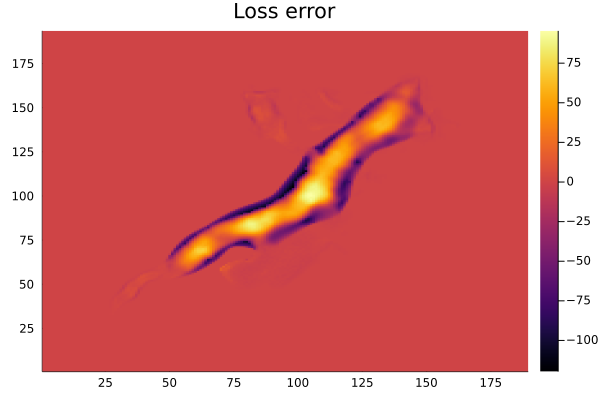

Values of predict_A in loss(): [1.0e-16 9.309295102739977e-17 8.618590205479956e-17 7.927885403324051e-17 7.237180727595225e-17]
Loss: 13.435434529008331
Values of predict_A in hybrid_train in hybrid_train(): [NaN NaN NaN NaN NaN]


┌ Info: Epoch 2
└ @ Main /Users/Bolib001/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Predicted YA: [NaN]


In [24]:
UA = Chain(
    Dense(1,10), 
    Dense(10,10, leakyrelu, init = Flux.glorot_normal), 
    Dense(10,5, leakyrelu, init = Flux.glorot_normal), 
    Dense(5,1) 
)

train!(UA) 

We plot the results

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/Bolib001/.julia/packages/PlotUtils/ebPq2/src/ticks.jl:295
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/Bolib001/.julia/packages/PlotUtils/ebPq2/src/ticks.jl:295


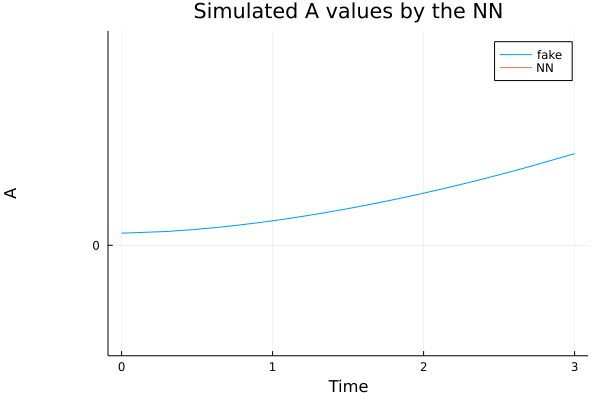

In [22]:
all_times = LinRange(0, t₁, 50)
# println("UD(all_times')': ",  UD_trained(all_times')')
plot(fakeA, 0, t₁, label="fake")
plot!(all_times, predict_A(UA, all_times')', title="Simulated A values by the NN", yaxis="A", xaxis="Time", label="NN")